In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)


### Dataset

In [10]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")


The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [11]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32,
                  kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64,
                  kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128,
                  kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),

        nn.Flatten(),
        nn.Linear(4 * 4 * 128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()


In [12]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10)  # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"


Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [13]:
# Hyperparameters
learning_rate = .02
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)


### Train model

In [14]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
sgd_train_loss_dict, sgd_test_loss_dict = trainer.train(num_epochs)


Training epoch 4: 100%|██████████| 937/937 [00:39<00:00, 23.73it/s]


In [15]:
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(
    f"SGD - Final Test loss: {final_loss}. SGD - Final Test accuracy: {final_acc}")

torch.random.manual_seed(0)
np.random.seed(0)

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)

model = create_model()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)
adam_train_loss_dict, adam_test_loss_dict = trainer.train(num_epochs)

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(
    f"Adam - Final Test loss: {final_loss}. Adam - Final Test accuracy: {final_acc}")


Training epoch 0:   0%|          | 3/937 [00:00<00:39, 23.76it/s]

SGD - Final Test loss: 0.0375545856920679. SGD - Final Test accuracy: 0.9878


Training epoch 4: 100%|██████████| 937/937 [00:36<00:00, 25.62it/s]


Adam - Final Test loss: 0.021551677751964454. Adam - Final Test accuracy: 0.9933


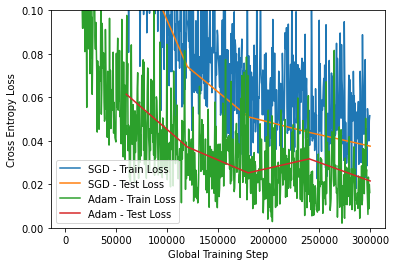

In [16]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(sgd_train_loss_dict, label="SGD - Train Loss")
utils.plot_loss(sgd_test_loss_dict, label="SGD - Test Loss")
utils.plot_loss(adam_train_loss_dict, label="Adam - Train Loss")
utils.plot_loss(adam_test_loss_dict, label="Adam - Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 0.1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()
